# Tooling to compare and assess annotations from different sources



In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Paper to be assessed
pmid = "3073535"

# Other parameters
gpt_version = "16"

# Get GPT outputs
gpt_files = [f for f in os.listdir("../gpt_ann/version" + gpt_version) if f.endswith(".ann")]

# get table from each of the files -> list of data.frames
gpt_tables = []
for gpt_file in gpt_files:
    with open(f"../gpt_ann/version16/{gpt_file}", "r") as f:
        # read tab-delimited file
        table = pd.read_csv(f, sep="\t", header=None)
        # add column names (if 6 columns)
        if table.shape[1] == 6:
            table.columns = ["ID", "Type", "Start", "End", "Text", "Quality"]
        elif table.shape[1] == 7: 
            table.columns = ["ID", "Type", "Start", "End", "Text", "Quality", "Extract"]

        # add column with file name + "gpt" + version
        table["File"] = gpt_file
        table["Source"] = "gpt_v" + gpt_version
        gpt_tables.append(table)


# Join all tables
gpt_table = pd.concat(gpt_tables)

In [109]:
# Extract comparison for each entity type
comparison  = []
for entity_type in gpt_table["Type"].unique():
    # Get entities from GPT
    entities = gpt_table[gpt_table["Type"] == entity_type]
    # Compare coordinates
    comparison.append({
        "Entity": entity_type,
        # Count of entities per file
        "Count": entities["File"].value_counts().to_dict()
    })
# Count per Text
comparison2 = []
for entity_type in gpt_table["Text"].unique():
    # Get entities from GPT
    entities = gpt_table[gpt_table["Text"] == entity_type]
    print(entities)
    # Compare coordinates
    comparison2.append({
        "Text": entities["Type"].unique() + ": " + entity_type,
        # Count of entities per file
        "Count": entities["Text"].value_counts().to_dict()
    })





   ID      Type  Start  End        Text   Quality  \
0  T1  Organism    104  112  SARS-CoV-2  Explicit   
1  T2  Organism    848  857  SARS-CoV-2  Explicit   

                                             Extract            File   Source  
0  Severe acute respiratory syndrome-related coro...  32619390_2.ann  gpt_v16  
1  ...The SARS-CoV-2 strain 2019-nCoV/Italy-INMI1...  32619390_1.ann  gpt_v16  
   ID          Type  Start   End     Text   Quality  \
1  T2  OrganismPart    920   926  Vero E6  Explicit   
0  T1  OrganismPart    611   617  Vero E6  Explicit   
2  T3  OrganismPart   1045  1051  Vero E6  Explicit   

                                             Extract            File   Source  
1  Vero E6 (ATCC, CLR-1586) cells were cultured a...  32619390_2.ann  gpt_v16  
0  ...Vero E6 (ATCC, CLR-1586) cells were culture...  32619390_1.ann  gpt_v16  
2  ...passages on Vero E6 cells and was stored at...  32619390_1.ann  gpt_v16  
   ID     Type  Start  End      Text   Quality  \
2  T3  Di

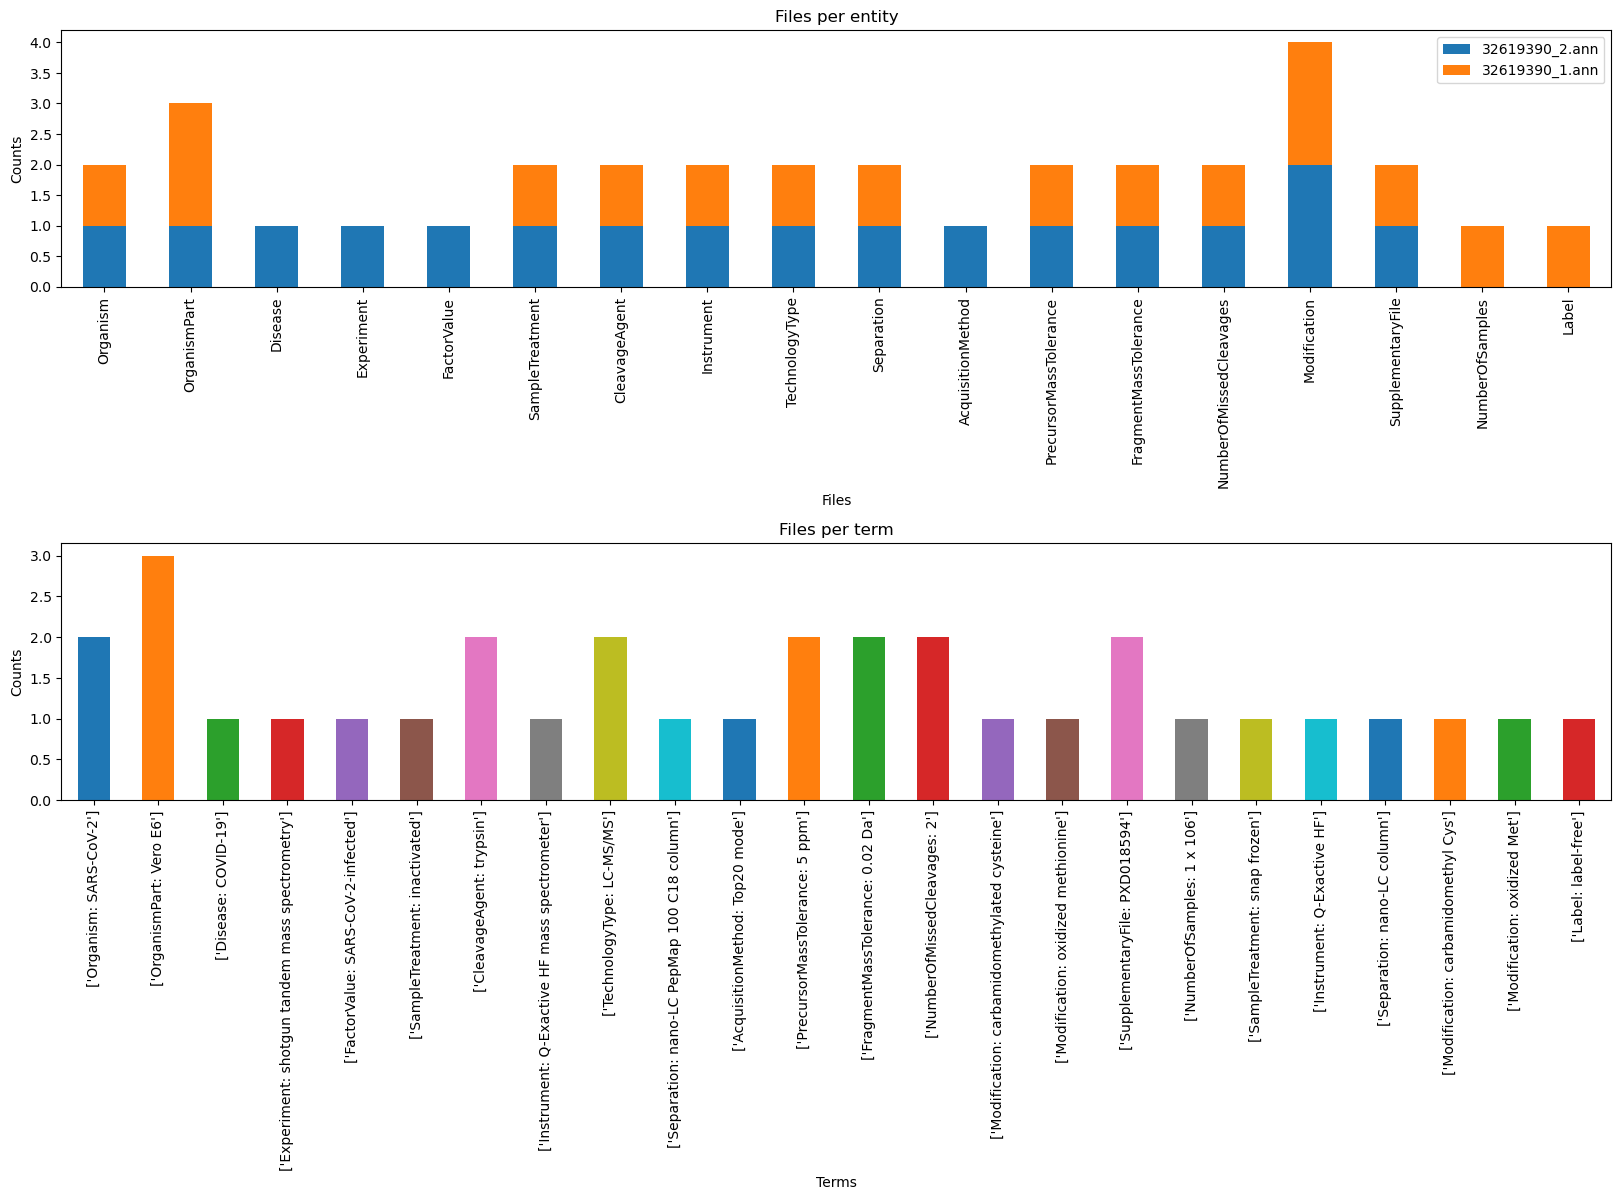

In [107]:
# Visualize comparisons
# visualize counts in one bar plot

# Create figure with enough space for x labels
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
# add space between subplots
plt.subplots_adjust(hspace=1)

# Create data frame
comparison_df = pd.DataFrame(comparison)
comparison2_df = pd.DataFrame(comparison2)
# Count of files per entities
count_df = pd.DataFrame(comparison_df["Count"].tolist()).fillna(0)
text_count_df = pd.DataFrame(comparison2_df["Count"].tolist()).fillna(0)
# Remove labels from "Count"
text_count_df.columns = [f"Files_{col}" for col in text_count_df.columns]

# Plot counts
count_df.plot(kind="bar", stacked=True, ax=ax[0])
# set entities as x labels
ax[0].set_xticklabels(comparison_df["Entity"])
ax[0].set_title("Files per entity")
ax[0].set_xlabel("Files")
ax[0].set_ylabel("Counts")

# plot values
text_count_df.plot(kind="bar", stacked=True, ax=ax[1])
# set entities as x labels
ax[1].set_xticklabels(comparison2_df["Text"])
ax[1].set_title("Files per term")
ax[1].set_xlabel("Terms")
ax[1].set_ylabel("Counts")
# no legend
ax[1].legend().set_visible(False)

In [108]:
# Create named vector with values
comparison2



[{'Text': array(['Organism: SARS-CoV-2'], dtype=object),
  'Count': {'SARS-CoV-2': 2}},
 {'Text': array(['OrganismPart: Vero E6'], dtype=object),
  'Count': {'Vero E6': 3}},
 {'Text': array(['Disease: COVID-19'], dtype=object),
  'Count': {'COVID-19': 1}},
 {'Text': array(['Experiment: shotgun tandem mass spectrometry'], dtype=object),
  'Count': {'shotgun tandem mass spectrometry': 1}},
 {'Text': array(['FactorValue: SARS-CoV-2-infected'], dtype=object),
  'Count': {'SARS-CoV-2-infected': 1}},
 {'Text': array(['SampleTreatment: inactivated'], dtype=object),
  'Count': {'inactivated': 1}},
 {'Text': array(['CleavageAgent: trypsin'], dtype=object),
  'Count': {'trypsin': 2}},
 {'Text': array(['Instrument: Q-Exactive HF mass spectrometer'], dtype=object),
  'Count': {'Q-Exactive HF mass spectrometer': 1}},
 {'Text': array(['TechnologyType: LC-MS/MS'], dtype=object),
  'Count': {'LC-MS/MS': 2}},
 {'Text': array(['Separation: nano-LC PepMap 100 C18 column'], dtype=object),
  'Count': {'nan